# Training our Fish Classifer
### Experimenting with Callbacks

In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

num_classes = 25
img_rows, img_cols = 32, 32
batch_size = 12

from keras.preprocessing.image import ImageDataGenerator

train_data_dir = './datasets/train'
validation_data_dir = './datasets/validation'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Using TensorFlow backend.


Found 1762 images belonging to 25 classes.
Found 881 images belonging to 25 classes.


### Let's define our model

In [5]:
model = Sequential()

# Padding = 'same'  results in padding the input such that
# the output has the same length as the original input
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape= (img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer and configure some parameters
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [6]:
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("/home/candy/Fresh/IDG/fresh_b12_e20.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 1762
nb_validation_samples = 881
epochs = 20

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
146/146 [==============================] - 30s 202ms/step - loss: 3.1973 - acc: 0.0588 - val_loss: 2.9355 - val_acc: 0.1473

Epoch 00001: val_loss improved from inf to 2.93551, saving model to /home/candy/Fresh/IDG/fresh_b12_e20.h5
Epoch 2/20
146/146 [==============================] - 11s 72ms/step - loss: 2.8924 - acc: 0.1404 - val_loss: 2.5953 - val_acc: 0.1922

Epoch 00002: val_loss improved from 2.93551 to 2.59528, saving model to /home/candy/Fresh/IDG/fresh_b12_e20.h5
Epoch 3/20
146/146 [==============================] - 10s 69ms/step - loss: 2.4950 - acc: 0.2216 - val_loss: 2.3151 - val_acc: 0.2509

Epoch 00003: val_loss improved from 2.59528 to 2.31512, saving model to /home/candy/Fresh/IDG/fresh_b12_e20.h5
Epoch 4/20
146/146 [==============================] - 10s 69ms/step - loss: 2.2041 - acc: 0.3025 - val_loss: 1.6461 - val_acc: 0.4902

Epoch 00004: val_loss improved from 2.31512 to 1.64611, saving model to /home/cand

### Displaying our Confusion Matrix

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0 20 13  0  0
   0]
 [ 0  0  0  0  0  0  0  0  4  0  1  0  1  1  0  0  0  0  0  0  0 15 13  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 21 14
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0 21
  13]
 [12  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  21]
 [19 14  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1
   0]
 [ 0 19 13  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   0]
 [ 0  0 19 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  2 16 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0 18 16  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0 19 11  2  0  0  0  0  0  0  0  0  0  0  0  0  0  2  1  0
   0]
 [ 2  0  0  0  0  0 17 15  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0 

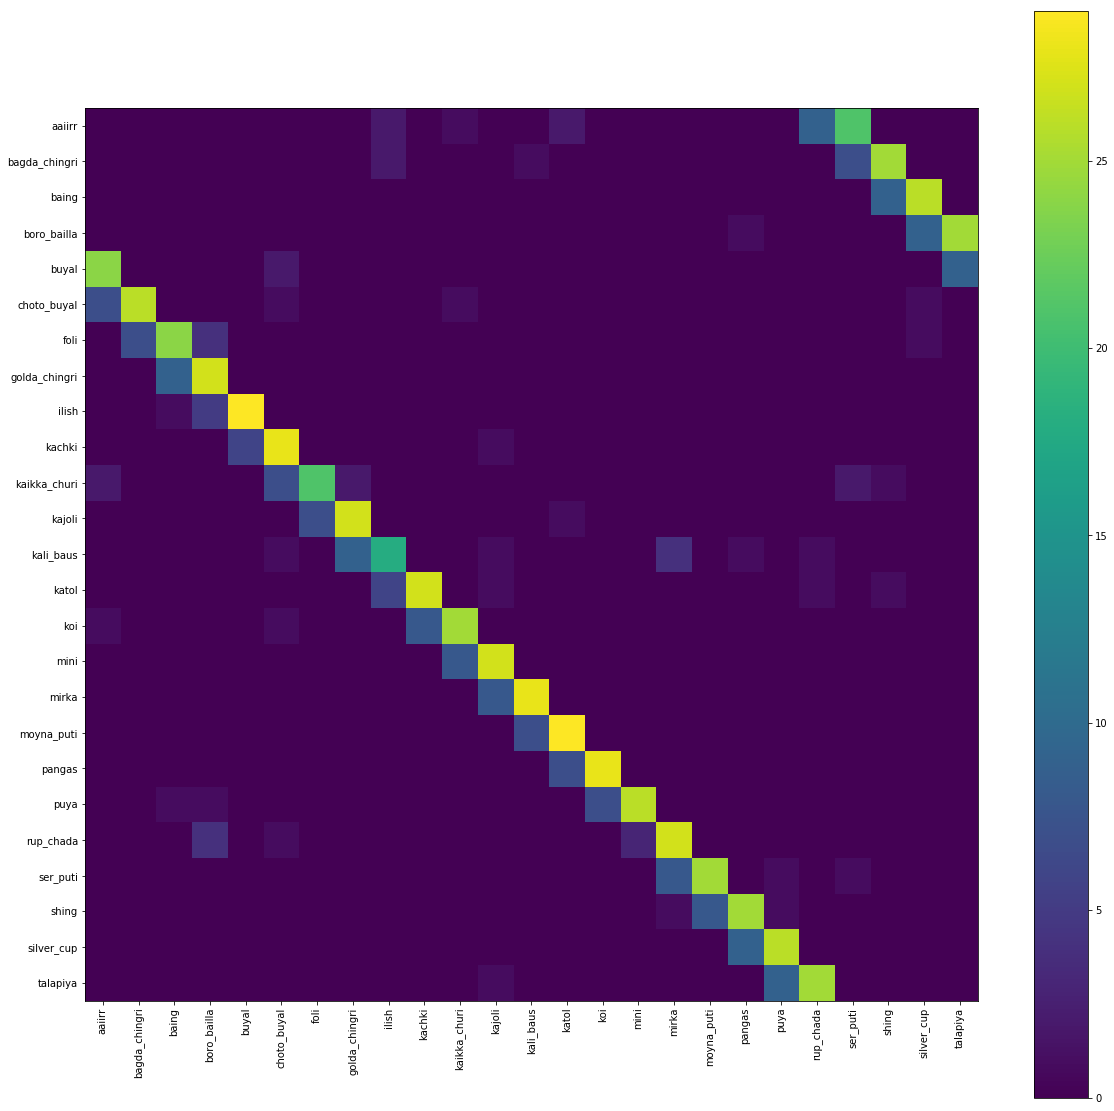

In [11]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 32,32,3
model = load_model('/home/candy/Fresh/IDG/fresh_b12_e20.h5')

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 1762
nb_validation_samples = 881

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

### Testing our fruit classifier

In [20]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 32, 32


files = []
predictions = []
true_labels = []
# predicting images
for i in range(0, 10):
    path = './datasets/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()